<h1 style="font-size:42px;text-align:center;border-radius:42px 42px;padding:32px;background:#8db8f7;color:#FFFFFF ">Face mask detection</h1>

In [1]:
 !pip install xmltodict

In [2]:
import time
import numpy as np
import pandas as pd 
import xmltodict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
from tqdm.autonotebook import tqdm, trange
import os

import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image

import sys
import torch.optim as optim
import torch.nn as nn

path_to_dir_data = '/kaggle/input'
path_annotations="/kaggle/input/face-mask-detection/annotations/"
path_image="/kaggle/input/face-mask-detection/images/"

device = torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [3]:
# get anotations and image filenames
def extract_img_annotations(path_to_dir_data: str):
    img_names=[] 
    xml_names=[] 
    for dirname, _, filenames in os.walk(path_to_dir_data):
        for filename in filenames:
            if os.path.join(dirname, filename)[-3:]!="xml":
                img_names.append(filename)
            else:
                xml_names.append(filename)
    return img_names , xml_names

# count classes
def count_classes(img_names: list) -> Counter:
    listing=[]
    for i in img_names[:]:
        with open(path_annotations+i[:-4]+".xml") as fd:
            doc=xmltodict.parse(fd.read())
        temp=doc["annotation"]["object"]
        if type(temp)==list:
            for i in range(len(temp)):
                listing.append(temp[i]["name"])
        else:
            listing.append(temp["name"])
            
    return Counter(listing)

# draw bounding boxes

def face_cas(img: str, path_annotations: str, path_image: str): 
    with open(path_annotations+img[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    image=plt.imread(os.path.join(path_image+img))
    fig,ax=plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10,5)
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            ###with_mask
            if temp[i]["name"]=="with_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
            ###without_mask
            if temp[i]["name"]=="without_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))     
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
            ###mask_weared_incorrect
            if temp[i]["name"]=="mask_weared_incorrect":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
    else:
        x,y,w,h=list(map(int,temp["bndbox"].values()))
        edgecolor={"with_mask":"g","without_mask":"r","mask_weared_incorrect":"y"}
        mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
    ax.imshow(image)
    ax.add_patch(mpatch)

# Create dataset 
def dataset_creation(image_list): 
    image_tensor=[]
    label_tensor=[]
    
    options={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2} 
    
    my_transform=transforms.Compose([transforms.Resize((226,226)),
                                 transforms.ToTensor()])
    
    for i,j in enumerate(image_list):
        with open(path_annotations+j[:-4]+".xml") as fd:
            doc=xmltodict.parse(fd.read())
        if type(doc["annotation"]["object"])!=list:
            temp=doc["annotation"]["object"]
            x,y,w,h=list(map(int,temp["bndbox"].values()))
            label=options[temp["name"]]
            image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"), y,x,h-y,w-x)
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label))
        else:
            temp=doc["annotation"]["object"]
            for k in range(len(temp)):
                x,y,w,h=list(map(int,temp[k]["bndbox"].values()))
                label=options[temp[k]["name"]]
                image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"),y,x,h-y,w-x)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label))
                
    final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)


In [4]:
 img_names , xml_names = extract_img_annotations(path_to_dir_data)

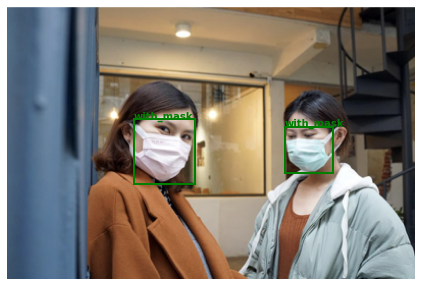

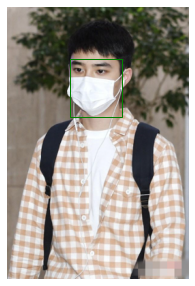

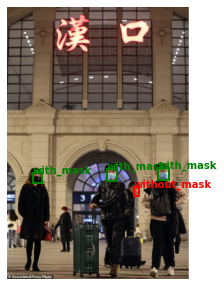

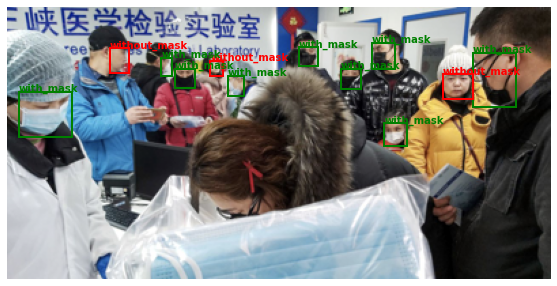

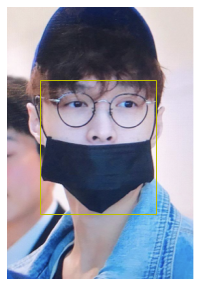

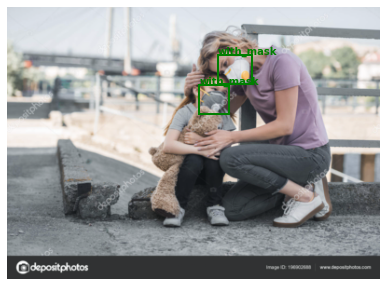

In [5]:
fun_images = img_names.copy()
for i in range(8,14):
    face_cas(fun_images[i], path_annotations, path_image)

In [6]:
mydataset=dataset_creation(img_names)

train_size=int(len(mydataset)*0.7)
test_size=len(mydataset)-train_size

trainset,testset=torch.utils.data.random_split(mydataset,[train_size,test_size])

train_dataloader =DataLoader(dataset=trainset,batch_size=16,shuffle=True,num_workers=4)
test_dataloader =DataLoader(dataset=testset,batch_size=16,shuffle=False,num_workers=4)

dataloader = {
    'train': train_dataloader
    ,
    'val': test_dataloader
}

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)



In [8]:
model=models.efficientnet_b3(pretrained=True)

for param in model.parameters():
    param.require_grad = True

model.classifier    
model.classifier = nn.Sequential(nn.Dropout(p=0.3),
                                              nn.Linear(1536, 3))

model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-4)

In [10]:
best_mode_wts = model.state_dict()

train_losses = []
eval_losses = []
best_loss = 10000000000
pbar = trange(4, desc='Epoch')

for epoch in pbar:
    
    for phase in ['train', 'val']:
        
        for inputs, labels in tqdm(dataloader[phase], leave=False, desc=f'{phase} iter'):
            
            if torch.cuda.is_available():
                inputs , labels = inputs.cuda(), labels.cuda()
                
            if phase == 'train':
                model.train(True)
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                outputs = model(inputs)
                loss_eval = criterion(outputs, labels)
                
        if phase == 'train':            
            train_losses.append(loss.item())
        else:
            eval_losses.append(loss_eval.item())
        
        if phase == 'val' and loss_eval.item() < best_loss:
                best_loss = loss_eval.item()
                best_model_wts = model.state_dict()
                
    pbar.set_description('{} Loss_train: {:.7f} Eval_losses: {:.7f}'.format(phase, loss.item(), loss_eval.item()))        
    
print('Best val loss: {:.10f}'.format(best_loss))

     
    



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

train iter:   0%|          | 0/179 [00:00<?, ?it/s]

val iter:   0%|          | 0/77 [00:00<?, ?it/s]

train iter:   0%|          | 0/179 [00:00<?, ?it/s]

val iter:   0%|          | 0/77 [00:00<?, ?it/s]

train iter:   0%|          | 0/179 [00:00<?, ?it/s]

val iter:   0%|          | 0/77 [00:00<?, ?it/s]

train iter:   0%|          | 0/179 [00:00<?, ?it/s]

val iter:   0%|          | 0/77 [00:00<?, ?it/s]

Best val loss: 0.0016669898


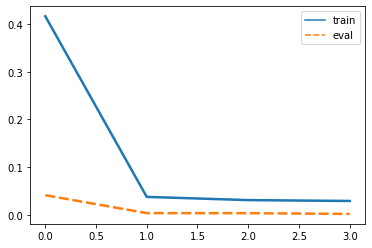

In [11]:
import seaborn as sns

sns.lineplot(data={'train':train_losses,'eval':eval_losses}, palette="tab10", linewidth=2.5)
plt.show()

In [12]:
import pickle

with open('model_efficientnet_b3_mask_class.pickle', 'wb') as f:
    pickle.dump(best_model_wts, f)